In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy.linalg import eigvalsh, qr, eigh

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['figure.dpi'] = 150

from time import time
from mpire import WorkerPool
from scipy.stats import sem

import os

import koala

from koala import pointsets, voronization, graph_color, example_graphs, flux_finder, hamiltonian, graph_utils
from koala import plotting as pl
from koala.lattice import Lattice, cut_boundaries
from koala import example_graphs as eg

import pickle

In [2]:
lattice, coloring, ujk = eg.make_amorphous(L = 70, open_boundary_conditions = False)
closed_boundary = (lattice, coloring, ujk)

In [3]:
lattice = cut_boundaries(lattice)
coloring = graph_color.color_lattice(lattice)
gs_flux_sector = np.array([eg.ground_state_ansatz(p.n_sides) for p in lattice.plaquettes], dtype=np.int8)
ujk = flux_finder.find_flux_sector(lattice, gs_flux_sector)

open_boundary = (lattice, coloring, ujk)

<AxesSubplot:>

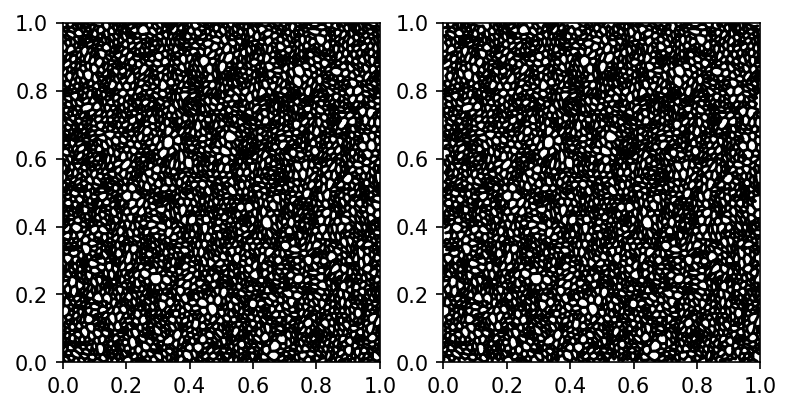

In [4]:
f, axes = plt.subplots(ncols = 2, figsize = (6,3))
pl.plot_edges(closed_boundary[0], ax = axes[0])
pl.plot_edges(open_boundary[0], ax = axes[1])

In [5]:
    import scipy.sparse.linalg

for (lattice, coloring, gs_ujk), name in [[open_boundary, "open"], [closed_boundary, "closed"]]:
    print(f"Doing {name} boundary conditions...")
    t0 = time()
    ham = hamiltonian.generate_majorana_hamiltonian(lattice, coloring, gs_ujk, J = np.array([1, 1, 1]))
    energies, vectors = np.linalg.eigh(ham)
    # energies, vectors = scipy.sparse.linalg.eigs(H, k=1, sigma=0) #can't do this because we want the IPR and DOS for the whole plot too

    edge_state_i = np.argsort(np.abs(energies))[0]

    edge_state = vectors[:, edge_state_i]
    edge_state_energy = energies[edge_state_i]
    edge_state_density = np.abs(edge_state)

    raw_IPR = np.sum(np.abs(vectors)**4, axis = 0)


    data = dict(
        lattice = lattice,
        coloring = coloring,
        gs_ujk = gs_ujk,
        energies = energies,
        edge_state_i = edge_state_i,
        edge_state = edge_state,
        edge_state_density = edge_state_density,
        raw_IPR = raw_IPR,
    )

    with open(f"big_solved_lattice_{name}_sparse.pickle", "wb") as f:
        pickle.dump(data, f)
    print(f"Did {name} boundary conditions in {(time() - t0)/60:.2f} mins")

Doing open boundary conditions...
Did open boundary conditions in 836.90s
Doing closed boundary conditions...
Did closed boundary conditions in 1084.67s
